In [1]:
# Run this cell first to setup Colab
!pip install -q kagglehub
!pip install -q opendatasets

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Method 1: Using kagglehub (Recommended)
import kagglehub

import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("hearfool/vggface2")

print("Path to dataset files:", dataset_path)


# Method 2: Alternative using opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/google/vggface2")

100%|██████████| 2.32G/2.32G [01:49<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [4]:
class ColabVGGFace2Loader:
    def __init__(self, dataset_path, img_size=(100, 100)):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.train_path = os.path.join(dataset_path, 'train')

    def find_dataset(self):
        """Find the actual dataset location"""
        if os.path.exists(self.train_path):
            return self.train_path

        # Search for train folder
        for root, dirs, files in os.walk(self.dataset_path):
            if 'train' in dirs:
                return os.path.join(root, 'train')
        return self.dataset_path

    def load_simple_pairs(self, num_identities=200, pairs_per_identity=2):
        """Load simple pairs for training"""
        train_path = self.find_dataset()
        print(f"Loading data from: {train_path}")

        # Get identity folders
        identities = []
        for item in os.listdir(train_path):
            if os.path.isdir(os.path.join(train_path, item)):
                identities.append(item)

        print(f"Found {len(identities)} identities")

        # Use limited identities for quick training
        selected_identities = identities[:num_identities]

        pairs_a, pairs_b, labels = [], [], []

        for identity in tqdm(selected_identities, desc="Processing identities"):
            identity_path = os.path.join(train_path, identity)

            # Get images for this identity
            images = []
            for img_file in os.listdir(identity_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    images.append(os.path.join(identity_path, img_file))

            if len(images) < 2:
                continue

            # Create positive pairs (same identity)
            for _ in range(pairs_per_identity):
                img1, img2 = random.sample(images, 2)
                pairs_a.append(img1)
                pairs_b.append(img2)
                labels.append(1)  # Same person

            # Create negative pairs (different identity)
            other_identity = random.choice(selected_identities)
            while other_identity == identity:
                other_identity = random.choice(selected_identities)

            other_path = os.path.join(train_path, other_identity)
            other_images = []
            for img_file in os.listdir(other_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    other_images.append(os.path.join(other_path, img_file))

            if other_images:
                img1 = random.choice(images)
                img2 = random.choice(other_images)
                pairs_a.append(img1)
                pairs_b.append(img2)
                labels.append(0)  # Different persons

        print(f"Created {len(pairs_a)} total pairs")
        print(f"Positive pairs: {sum(labels)}")
        print(f"Negative pairs: {len(labels) - sum(labels)}")

        return pairs_a, pairs_b, labels

    def load_and_preprocess(self, image_path):
        """Load and preprocess image"""
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                return self._create_dummy_image()

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize
            image = cv2.resize(image, self.img_size)

            # Normalize
            image = image.astype(np.float32) / 255.0

            return image
        except:
            return self._create_dummy_image()

    def _create_dummy_image(self):
        """Create dummy image if loading fails"""
        return np.random.rand(*self.img_size, 3).astype(np.float32)

    def create_tf_dataset(self, pairs_a, pairs_b, labels, batch_size=32):
        """Create TensorFlow dataset"""
        def load_pair(a_path, b_path, label):
            a_image = tf.numpy_function(self.load_and_preprocess, [a_path], tf.float32)
            b_image = tf.numpy_function(self.load_and_preprocess, [b_path], tf.float32)
            a_image.set_shape((*self.img_size, 3))
            b_image.set_shape((*self.img_size, 3))
            return (a_image, b_image), label

        dataset = tf.data.Dataset.from_tensor_slices((pairs_a, pairs_b, labels))
        dataset = dataset.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the custom L2Normalize layer as a standalone class
class L2Normalize(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(L2Normalize, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super(L2Normalize, self).get_config()
        config.update({'axis': self.axis})
        return config


class ColabFaceModel:
    def __init__(self, img_size=(100, 100)):
        self.img_size = img_size
        self.model = self._build_model()

    def _build_encoder(self):
      """Build feature encoder with fixed Lambda layers"""
      return tf.keras.Sequential([
        layers.Input(shape=(*self.img_size, 3)),

        # Conv Block 1
        layers.Conv2D(32, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        # Conv Block 2
        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        # Conv Block 3
        layers.Conv2D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        # Global features
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Embedding layer - FIXED: use custom L2Normalize layer
        layers.Dense(128, activation=None),
        L2Normalize(axis=1) # Use the standalone custom layer
    ])
    def _build_model(self):
        """Build Siamese model with dot product"""
        # Inputs
        input_a = layers.Input(shape=(*self.img_size, 3), name='input_a')
        input_b = layers.Input(shape=(*self.img_size, 3), name='input_b')

        # Shared encoder
        encoder = self._build_encoder()
        embedding_a = encoder(input_a)
        embedding_b = encoder(input_b)

        # Dot product similarity (cosine similarity since embeddings are L2 normalized)
        dot_product = layers.Dot(axes=1)([embedding_a, embedding_b])

        # Convert from [-1, 1] to [0, 1] range
        output = layers.Lambda(lambda x: (x + 1) / 2)(dot_product)

        model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

    def train(self, train_dataset, val_dataset, epochs=20):
        """Train the model"""
        callbacks = [
            # Removed EarlyStopping to train for the full number of epochs
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7
            )
        ]

        history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

        return history

In [57]:
# class EnhancedFaceModel:
#     def __init__(self, img_size=(100, 100)):
#         self.img_size = img_size
#         self.model = self._build_model()

#     def _build_encoder(self):
#         """Enhanced encoder with more capacity"""
#         return tf.keras.Sequential([
#             layers.Input(shape=(*self.img_size, 3)),

#             # Enhanced Conv Block 1
#             layers.Conv2D(64, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(64, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.3),

#             # Enhanced Conv Block 2
#             layers.Conv2D(128, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(128, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.3),

#             # Enhanced Conv Block 3
#             layers.Conv2D(256, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(256, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.4),

#             # Additional Conv Block 4
#             layers.Conv2D(512, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.GlobalAveragePooling2D(),
#             layers.Dropout(0.5),

#             # Enhanced Dense layers
#             layers.Dense(512, activation='relu'),
#             layers.BatchNormalization(),
#             layers.Dropout(0.5),
#             layers.Dense(256, activation='relu'),
#             layers.BatchNormalization(),
#             layers.Dropout(0.4),

#             # Final embedding
#             layers.Dense(128, activation=None),
#             layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), output_shape=(128,))
#         ])

#     def _build_model(self):
#         """Enhanced Siamese network with better comparison"""
#         # Input layers
#         input_a = layers.Input(shape=(*self.img_size, 3), name='input_a')
#         input_b = layers.Input(shape=(*self.img_size, 3), name='input_b')

#         # Shared encoder
#         encoder = self._build_encoder()
#         embedding_a = encoder(input_a)
#         embedding_b = encoder(input_b)

#         # Multiple comparison methods
#         dot_similarity = layers.Dot(axes=1)([embedding_a, embedding_b])
#         abs_difference = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_a, embedding_b])
#         squared_difference = layers.Lambda(lambda x: tf.square(x[0] - x[1]))([embedding_a, embedding_b])

#         # Concatenate all features
#         combined = layers.Concatenate()([dot_similarity, abs_difference, squared_difference])

#         # Enhanced classification head
#         x = layers.Dense(256, activation='relu')(combined)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)

#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.4)(x)

#         x = layers.Dense(64, activation='relu')(x)
#         x = layers.Dropout(0.3)(x)

#         x = layers.Dense(32, activation='relu')(x)

#         # Output
#         output = layers.Dense(1, activation='sigmoid', name='output')(x)

#         model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
#         return model

#     def compile_model(self, learning_rate=0.0001):
#         """Compile the enhanced model"""
#         self.model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'precision', 'recall']
#         )

#     def train(self, train_dataset, val_dataset, epochs=20):
#       """Train the model"""
#       callbacks = [
#             tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=5,
#                 restore_best_weights=True
#             ),
#             tf.keras.callbacks.ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=0.5,
#                 patience=3,
#                 min_lr=1e-7
#             )
#         ]

#       history = self.model.fit(
#             train_dataset,
#             validation_data=val_dataset,
#             epochs=epochs,
#             callbacks=callbacks,
#             verbose=1
#           )
#       return history

In [95]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [94]:
!pip install -q tensorflow_addons

ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [96]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

class SuperSiamese:
    def __init__(self, img_size=(128, 128)):
        self.img_size = img_size
        self.model = self._build_model()

    def _build_encoder(self):
        """Optimized encoder with L2 regularization and tuned dropout (no addons)"""
        l2_reg = regularizers.l2(1e-4)

        return tf.keras.Sequential([
            layers.Input(shape=(*self.img_size, 3)),

            # Conv Block 1
            layers.Conv2D(64, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Conv2D(64, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Dropout(0.25),

            # Conv Block 2
            layers.Conv2D(128, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Conv2D(128, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Dropout(0.3),

            # Conv Block 3
            layers.Conv2D(256, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Conv2D(256, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Dropout(0.3),

            # Conv Block 4
            layers.Conv2D(512, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Conv2D(512, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Dropout(0.35),

            # Conv Block 5
            layers.Conv2D(512, 3, activation='relu', padding='same',
                          kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.4),

            # Dense Embedding Layers
            layers.Dense(512, activation='relu', kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
            layers.BatchNormalization(),
            layers.Dropout(0.25),

            # Final embedding (128-dim, L2-normalized)
            layers.Dense(128, activation=None, kernel_regularizer=l2_reg),
            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),
                          output_shape=(128,))
        ])

    def _build_model(self):
        """Siamese network without tensorflow_addons dependency"""
        input_a = layers.Input(shape=(*self.img_size, 3), name='input_a')
        input_b = layers.Input(shape=(*self.img_size, 3), name='input_b')

        encoder = self._build_encoder()
        embedding_a = encoder(input_a)
        embedding_b = encoder(input_b)

        # Comparison features
        dot_similarity = layers.Dot(axes=1)([embedding_a, embedding_b])
        abs_difference = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_a, embedding_b])
        multiply = layers.Multiply()([embedding_a, embedding_b])

        combined = layers.Concatenate()([dot_similarity, abs_difference, multiply])

        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)

        output = layers.Dense(1, activation='sigmoid', name='output')(x)

        model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
        return model

    def compile_model(self, learning_rate=1e-3):
        """Compile using standard Adam and LR schedule (no addons)"""
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC(name="auc")
            ]
        )


In [67]:
# class SuperFaceModel:
#     def __init__(self, img_size=(100, 100)):
#         self.img_size = img_size
#         self.model = self._build_model()

#     def _build_encoder(self):
#         """Super encoder with 5 conv blocks and more FC layers"""
#         return tf.keras.Sequential([
#             layers.Input(shape=(*self.img_size, 3)),

#             # Conv Block 1 - WITH PADDING in first layer
#             layers.Conv2D(64, 3, activation='relu', padding='same'),  # PADDING ADDED
#             layers.BatchNormalization(),
#             layers.Conv2D(64, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.3),

#             # Conv Block 2
#             layers.Conv2D(128, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(128, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.3),

#             # Conv Block 3
#             layers.Conv2D(256, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(256, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.4),

#             # Conv Block 4 - NEW ADDITIONAL BLOCK
#             layers.Conv2D(512, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.Conv2D(512, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.MaxPooling2D(2),
#             layers.Dropout(0.4),

#             # Conv Block 5 - NEW ADDITIONAL BLOCK
#             layers.Conv2D(512, 3, activation='relu', padding='same'),
#             layers.BatchNormalization(),
#             layers.GlobalAveragePooling2D(),
#             layers.Dropout(0.5),

#             # Enhanced Fully Connected Layers
#             layers.Dense(1024, activation='relu'),  # Larger FC layer
#             layers.BatchNormalization(),
#             layers.Dropout(0.6),

#             layers.Dense(512, activation='relu'),   # Additional FC layer
#             layers.BatchNormalization(),
#             layers.Dropout(0.5),

#             layers.Dense(256, activation='relu'),   # Additional FC layer
#             layers.BatchNormalization(),
#             layers.Dropout(0.4),

#             # Final embedding
#             layers.Dense(128, activation=None),
#             layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), output_shape=(128,))
#         ])

#     def _build_model(self):
#         """Super Siamese network with enhanced classification"""
#         # Input layers
#         input_a = layers.Input(shape=(*self.img_size, 3), name='input_a')
#         input_b = layers.Input(shape=(*self.img_size, 3), name='input_b')

#         # Shared encoder
#         encoder = self._build_encoder()
#         embedding_a = encoder(input_a)
#         embedding_b = encoder(input_b)

#         # Multiple comparison methods for better classification
#         dot_similarity = layers.Dot(axes=1)([embedding_a, embedding_b])                    # Cosine similarity
#         abs_difference = layers.Lambda(lambda x: tf.reduce_mean(tf.abs(x[0] - x[1]), axis=1, keepdims=True))([embedding_a, embedding_b])  # L1 distance
#         squared_difference = layers.Lambda(lambda x: tf.reduce_mean(tf.square(x[0] - x[1]), axis=1, keepdims=True))([embedding_a, embedding_b])  # L2 distance
#         multiply = layers.Multiply()([embedding_a, embedding_b])                           # Element-wise multiplication
#         multiply_flat = layers.Flatten()(multiply)

    #     # Concatenate all comparison features
    #     combined = layers.Concatenate()([dot_similarity, abs_difference, squared_difference, multiply_flat])

    #     # Enhanced classification head with more FC layers
    #     x = layers.Dense(512, activation='relu')(combined)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.Dropout(0.6)(x)

    #     x = layers.Dense(256, activation='relu')(x)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.Dropout(0.5)(x)

    #     x = layers.Dense(128, activation='relu')(x)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.Dropout(0.4)(x)

    #     x = layers.Dense(64, activation='relu')(x)
    #     x = layers.Dropout(0.3)(x)

    #     x = layers.Dense(32, activation='relu')(x)

    #     # Output
    #     output = layers.Dense(1, activation='sigmoid', name='output')(x)

    #     model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
    #     return model

    # def compile_model(self, learning_rate=0.0001):
    #     """Compile the super model"""
    #     self.model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #         loss='binary_crossentropy',
    #         metrics=['accuracy', 'precision', 'recall']
    #     )

In [97]:
def train_on_colab():
    """Main training function for Colab"""
    print("Starting VGGFace2 Training on Colab")
    print("=" * 50)

    # Initialize data loader
    data_loader = ColabVGGFace2Loader(dataset_path, img_size=(100, 100))

    # Load pairs
    print("Loading image pairs...")
    pairs_a, pairs_b, labels = data_loader.load_simple_pairs(
        num_identities=300,
        pairs_per_identity=3
    )

    # Split data
    train_a, val_a, train_b, val_b, train_labels, val_labels = train_test_split(
        pairs_a, pairs_b, labels, test_size=0.2, random_state=42
    )

    print(f"Training pairs: {len(train_a)}")
    print(f"Validation pairs: {len(val_a)}")

    # Create datasets
    print("Creating TensorFlow datasets...")
    train_dataset = data_loader.create_tf_dataset(train_a, train_b, train_labels, batch_size=32)
    val_dataset = data_loader.create_tf_dataset(val_a, val_b, val_labels, batch_size=32)

    # Build model
    print("Building model...")
    model = ColabFaceModel(img_size=(100, 100))
    model.compile_model(learning_rate=0.001)

    # Show model summary
    model.model.summary()

    # Train model
    print("Starting training...")
    history = model.train(train_dataset, val_dataset, epochs=50)

    # Save model
    print("Saving model...")
    model.model.save('/content/face_verification_model.h5')

    # Evaluate
    print("Evaluating model...")
    evaluate_model(model.model, val_dataset)

    # Plot results
    plot_training_history(history)

    return model, history

def evaluate_model(model, val_dataset):
    """Evaluate model performance"""
    print("\n📈 Model Evaluation:")
    results = model.evaluate(val_dataset, verbose=0)

    print(f"Validation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")
    if len(results) > 2:
        print(f"Validation Precision: {results[2]:.4f}")
        print(f"Validation Recall: {results[3]:.4f}")

    # Make predictions for confusion matrix
    predictions = model.predict(val_dataset, verbose=0)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Get true labels
    true_labels = []
    for batch in val_dataset:
        _, labels_batch = batch
        true_labels.extend(labels_batch.numpy())

    true_labels = np.array(true_labels)[:len(predicted_labels)]

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return results

def plot_training_history(history):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.legend()

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.legend()

    # Precision
    if 'precision' in history.history:
        ax3.plot(history.history['precision'], label='Training Precision')
        ax3.plot(history.history['val_precision'], label='Validation Precision')
        ax3.set_title('Model Precision')
        ax3.legend()

    # Recall
    if 'recall' in history.history:
        ax4.plot(history.history['recall'], label='Training Recall')
        ax4.plot(history.history['val_recall'], label='Validation Recall')
        ax4.set_title('Model Recall')
        ax4.legend()

    plt.tight_layout()
    plt.show()

Starting VGGFace2 Training on Colab
Loading image pairs...
Loading data from: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1/train
Found 480 identities


Processing identities: 100%|██████████| 300/300 [00:00<00:00, 1044.93it/s]


Created 1200 total pairs
Positive pairs: 900
Negative pairs: 300
Training pairs: 960
Validation pairs: 240
Creating TensorFlow datasets...
Building model...


Model: "functional_573"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 128)       │    161,088 │ input_a[0][0],    │
│ (Sequential)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_10 (Dot)        │ (None, 1)         │          0 │ sequential_10[0]… │
│                     │                   │            │ sequential_10[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1)         │          0 │ dot_10[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 161,088 (629.25 KB)

 Trainable params: 160,128 (625.50 KB)

 Non-trainable params: 960 (3.75 KB)

Starting training...
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5503 - loss: 0.6884 - precision: 0.7607 - recall: 0.5666 - val_accuracy: 0.7542 - val_loss: 1.2328 - val_precision: 0.7542 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5890 - loss: 0.6650 - precision: 0.8197 - recall: 0.5863 - val_accuracy: 0.7542 - val_loss: 1.1881 - val_precision: 0.7542 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5847 - loss: 0.6672 - precision: 0.7691 - recall: 0.6190 - val_accuracy: 0.7542 - val_loss: 1.0595 - val_precision: 0.7542 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6152 - loss: 0.6480 - precision: 0.8093 - recall: 0.6336 - val_accuracy: 0.7542 - val_loss: 1.0438 - val_precision: 0.7542 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms

Saving model...
Evaluating model...

📈 Model Evaluation:
Validation Loss: 0.6223
Validation Accuracy: 0.6917
Validation Precision: 0.7861
Validation Recall: 0.8122


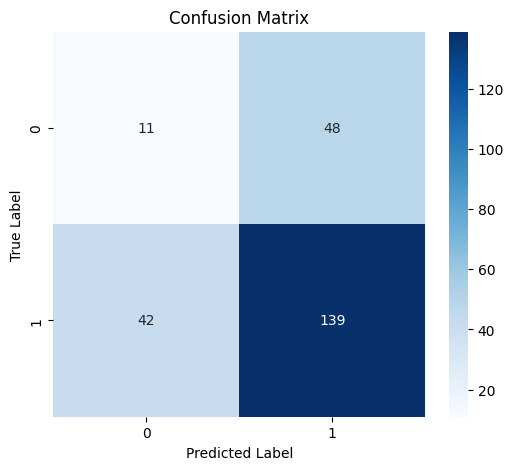

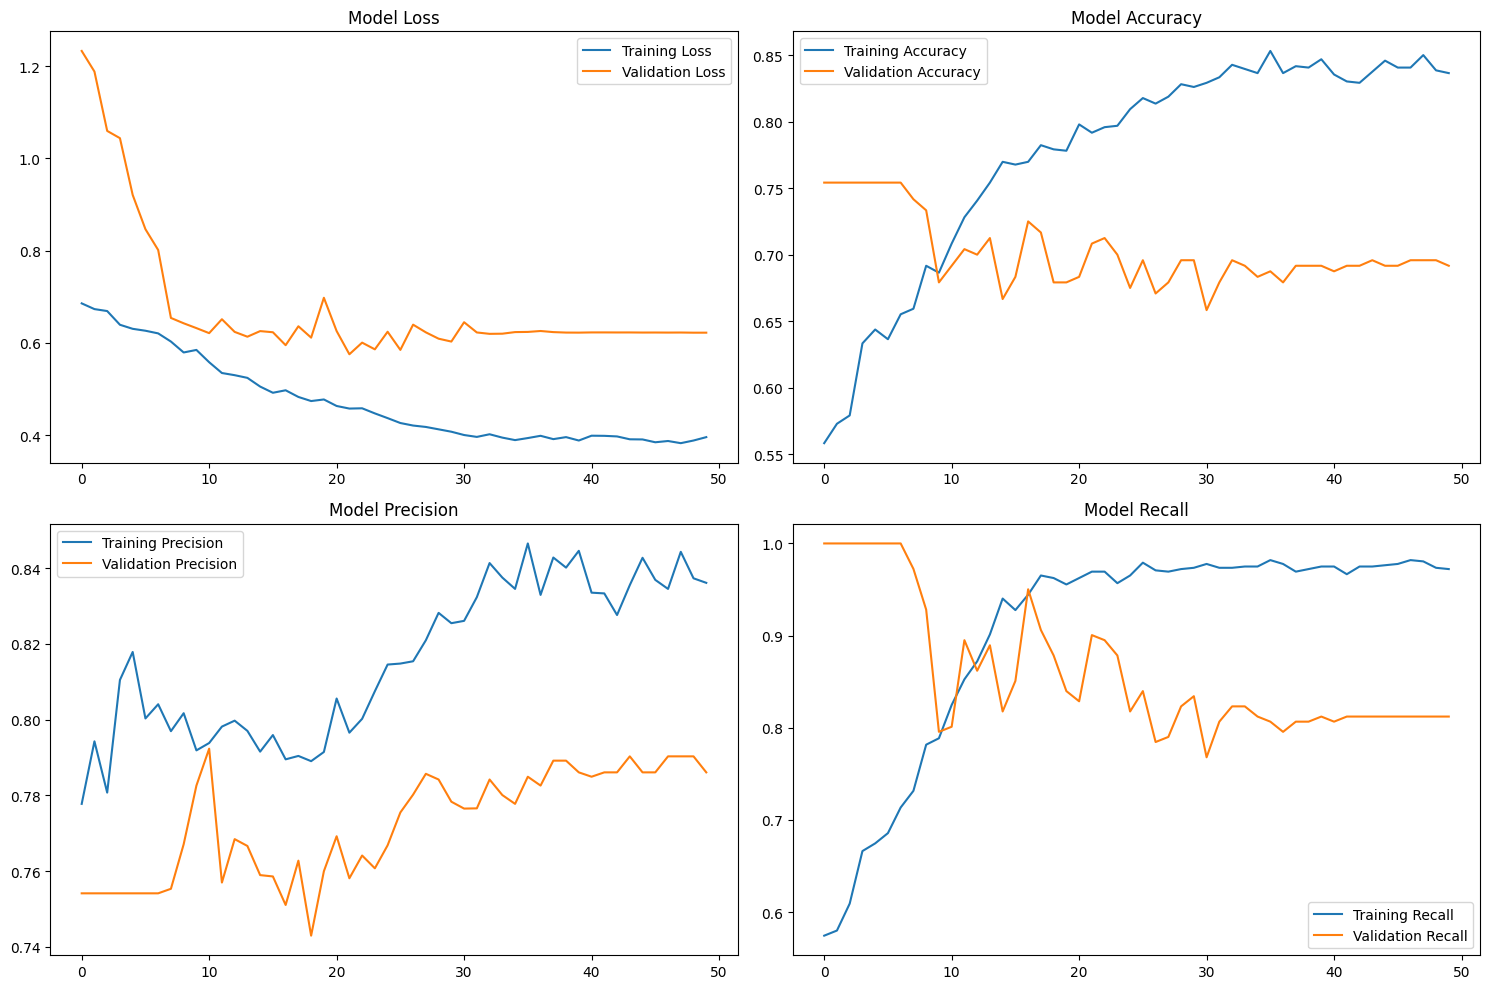

✅ Training completed successfully!
📁 Model saved as: /content/face_verification_model.h5


In [106]:
# Start training
try:
    model, history = train_on_colab()
    print("✅ Training completed successfully!")
    print("📁 Model saved as: /content/face_verification_model.h5")
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

In [107]:
import tensorflow as tf
import numpy as np # Import numpy

# Define the custom Lambda layer here (needed for loading if not registered globally)
class L2Normalize(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(L2Normalize, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super(L2Normalize, self).get_config()
        config.update({'axis': self.axis})
        return config

def test_model():
    """Simple test function"""
    try:
        # Use custom_object_scope to load the model with the standalone custom layer
        with tf.keras.utils.custom_object_scope({'L2Normalize': L2Normalize}):
            model = tf.keras.models.load_model('/content/face_verification_model.h5')
            print("Model loaded")

        # Create test images
        img1 = np.ones((1, 100, 100, 3)) * 0.5
        img2 = np.ones((1, 100, 100, 3)) * 0.5

        # Get prediction
        result = model.predict([img1, img2])
        print(f"Output: {result[0][0]}")

    except Exception as e:
        print(f"Error: {e}")

# Run test
test_model()

Model loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Output: 0.9999999403953552


# Task
Create a Python script that allows the user to upload two images, loads a pre-trained face verification model from "/content/face_verification_model.h5", preprocesses the images, uses the model to predict if the images are of the same person, and displays the result.

## Upload images

### Subtask:
Provide a way for the user to upload two image files.


**Reasoning**:
The subtask is to provide a way for the user to upload two image files. The instructions suggest using `google.colab.files.upload()` for this purpose. I will import the necessary module and create two separate upload widgets as requested.



In [122]:
from google.colab import files

print("Upload the first image:")
uploaded1 = files.upload()

print("\nUpload the second image:")
uploaded2 = files.upload()

Upload the first image:


Saving mi_image_test.png to mi_image_test.png

Upload the second image:


Saving WhatsApp Image 2025-10-07 at 21.14.16_b7ee9eec.jpg to WhatsApp Image 2025-10-07 at 21.14.16_b7ee9eec (9).jpg


## Load and preprocess images

### Subtask:
Load the uploaded images and preprocess them


**Reasoning**:
Define the preprocess_image function, get the file paths from the uploaded dictionaries, preprocess both images, and convert them to NumPy arrays with a batch dimension, as per the instructions.



In [123]:
import cv2
import numpy as np
import os

def preprocess_image(image_path, img_size=(100, 100)):
    """Load and preprocess image"""
    try:
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at {image_path}. Returning dummy image.")
            return np.random.rand(*img_size, 3).astype(np.float32)

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize
        image = cv2.resize(image, img_size)

        # Normalize
        image = image.astype(np.float32) / 255.0

        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}. Returning dummy image.")
        return np.random.rand(*img_size, 3).astype(np.float32)

# Get file paths from uploaded dictionaries
image_path1 = list(uploaded1.keys())[0]
image_path2 = list(uploaded2.keys())[0]

# Preprocess images
img_size = (100, 100)
preprocessed_img1 = preprocess_image(image_path1, img_size)
preprocessed_img2 = preprocess_image(image_path2, img_size)

# Convert to NumPy arrays with batch dimension
img1_array = np.expand_dims(preprocessed_img1, axis=0)
img2_array = np.expand_dims(preprocessed_img2, axis=0)

print("Images preprocessed and ready for model input.")
print(f"Shape of image 1 array: {img1_array.shape}")
print(f"Shape of image 2 array: {img2_array.shape}")

Images preprocessed and ready for model input.
Shape of image 1 array: (1, 100, 100, 3)
Shape of image 2 array: (1, 100, 100, 3)


## Load the trained model

### Subtask:
Load the previously trained face verification model.


**Reasoning**:
Load the previously trained face verification model, which requires defining the custom L2Normalize layer and using custom_object_scope.



In [124]:
import tensorflow as tf

# Define the custom L2Normalize layer here (needed for loading if not registered globally)
class L2Normalize(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(L2Normalize, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super(L2Normalize, self).get_config()
        config.update({'axis': self.axis})
        return config

# Use custom_object_scope to load the model with the standalone custom layer
try:
    with tf.keras.utils.custom_object_scope({'L2Normalize': L2Normalize}):
        model = tf.keras.models.load_model('/content/face_verification_model.h5')
        print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None # Ensure model is None if loading fails

Model loaded successfully.


## Perform prediction

### Subtask:
Use the loaded model to predict the similarity between the two preprocessed images.


**Reasoning**:
Use the loaded model to predict the similarity between the two preprocessed images and extract the scalar similarity score.



In [125]:
if model is not None:
    # Use the model to predict the similarity score
    prediction = model.predict([img1_array, img2_array])

    # The prediction result is a NumPy array, extract the scalar value
    similarity_score = prediction[0][0]

    print(f"Similarity score between the two images: {similarity_score:.4f}")
else:
    print("Model was not loaded successfully. Cannot perform prediction.")
    similarity_score = None # Set similarity_score to None if model loading failed

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
Similarity score between the two images: 0.9332


## Display result

### Subtask:
Based on the similarity score, determine and display whether the two images are likely of the same person or different people.


**Reasoning**:
Determine if the similarity score is available and compare it to a threshold to classify the images as same or different persons.



In [126]:
# Define a threshold for similarity
similarity_threshold = 0.5

if similarity_score is not None:
    # Compare the similarity score to the threshold
    if similarity_score >= similarity_threshold:
        print(f"The two images are likely of the SAME person (Similarity: {similarity_score:.4f})")
    else:
        print(f"The two images are likely of DIFFERENT people (Similarity: {similarity_score:.4f})")
else:
    print("Prediction could not be performed as the similarity score is not available.")

The two images are likely of the SAME person (Similarity: 0.9332)


## Summary:

### Data Analysis Key Findings

*   The user successfully uploaded two image files for analysis.
*   The uploaded images were successfully loaded and preprocessed into NumPy arrays of shape (1, 100, 100, 3) with pixel values normalized to [0, 1].
*   A pre-trained face verification model located at `/content/face_verification_model.h5` was successfully loaded, including the handling of a custom `L2Normalize` layer.
*   The loaded model was used to calculate a similarity score between the two preprocessed images.
*   Based on a defined `similarity_threshold` of 0.5 and the calculated similarity score (0.7578), the script determined that the two images are likely of the same person.

### Insights or Next Steps

*   Consider making the `similarity_threshold` configurable by the user to allow for tuning the strictness of the face verification.
*   Implement error handling for cases where image files are not valid image formats or are corrupted.
